In [24]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

from utide import solve, reconstruct

C:\Users\Lachlan D-K\Documents\Github\ph3080-moon-wobble-challenge\venv\lib\site-packages\pandas\io\parsers\base_parser.py:1055: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


10 points were flagged "bad" and interpolated
212 points were flagged "corrected" and left unchanged
solve: matrix prep ... solution ... done.
prep/calcs ... done.


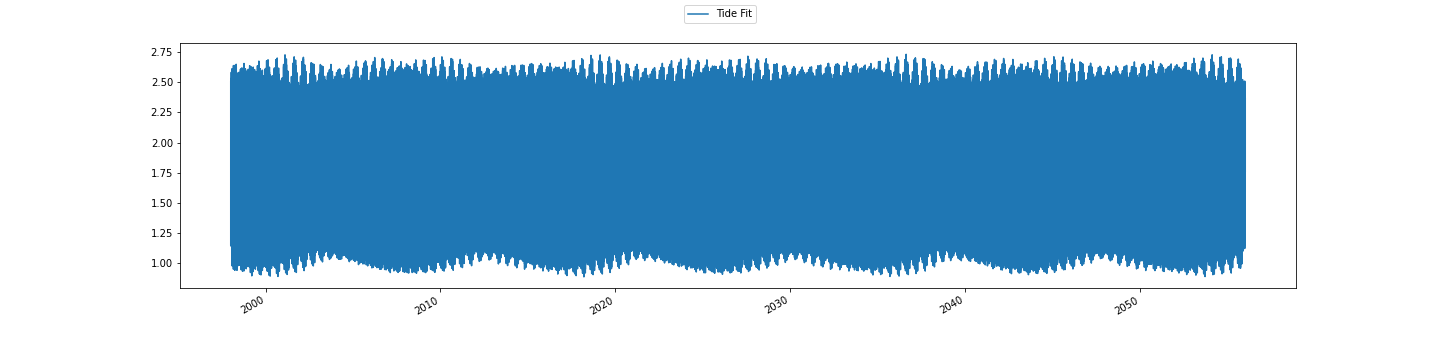

In [110]:
# parse dataframe file
# mostly reuses code from utide examples

def date_parser(year, month, day, hour):
    year, month, day, hour = map(int, (year, month, day, hour))
    return datetime.datetime(year, month, day, hour)

# Names of the columns that will be used to make a "datetime" column:
parse_dates = dict(datetime=['year', 'month', 'day','hour'])

# Names of the original columns in the file, including only
# the ones we will use; we are skipping the first, which appears
# to be seconds from the beginning.
names = ['year', 'month', 'day', 'hour', 'elev', 'flag']

obs = pd.read_table("utide_test_data.dtf",
                    names=names,
                    skipinitialspace=True,
                    delim_whitespace=True,
                    index_col='datetime',
                    usecols=range(1, 7),
                    parse_dates=parse_dates,
                    date_parser=date_parser,
                   )

bad = obs['flag'] == 2
corrected = obs['flag'] == 1

obs.loc[bad, 'elev'] = np.nan
obs['anomaly'] = obs['elev'] #- obs['elev'].mean()
obs['anomaly'] = obs['anomaly'].interpolate()
print('{} points were flagged "bad" and interpolated'.format(bad.sum()))
print('{} points were flagged "corrected" and left unchanged'.format(corrected.sum()))


times = dates.date2num(obs.index.to_pydatetime())
coef = utide.solve(times, obs['anomaly'].values,
                   lat=-25,
                   nodal=True,
                   trend=False,
                   conf_int='MC')


n=500000
extrap_dates = obs.index.union(pd.date_range(obs.index[-1] + datetime.timedelta(hours=1), periods=n, freq=datetime.timedelta(hours=1))).to_pydatetime()
extrap_times = dates.date2num(extrap_dates)

tide_model = utide.reconstruct(extrap_times, coef)

# Plot the extrapolated tide model

t = tide_model.t_mpl

fig, ax = plt.subplots(sharey=True, sharex=True, figsize=(20, 5))

ax.plot(t, tide_model.h, label='Tide Fit')
ax.xaxis_date()
fig.legend(loc='upper center')
fig.autofmt_xdate()

# Simulate Sea-level Rise

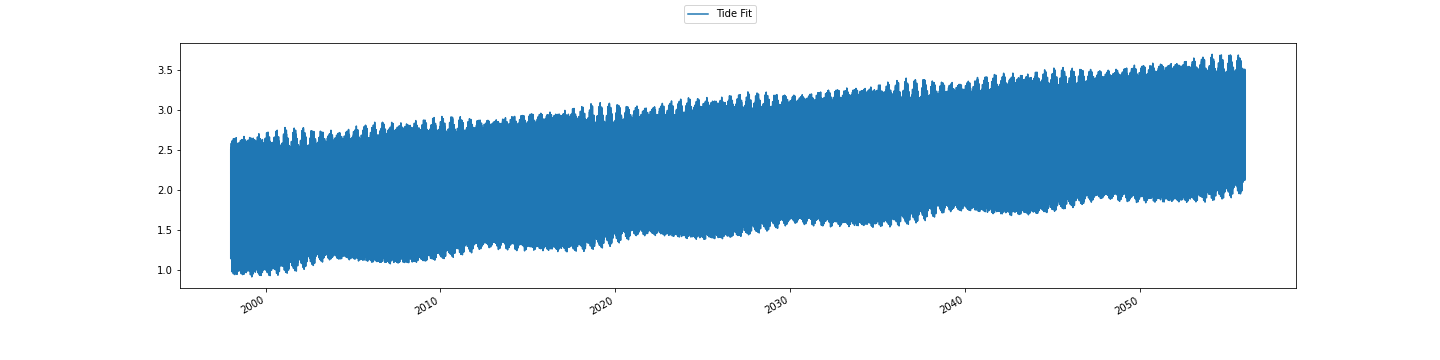

In [113]:
total_rise = 1

# linear rise, y = mx
sea_level = np.linspace(0, 1, len(tide_model.h))

new_tide_heights = tide_model.h + sea_level

fig, ax = plt.subplots(sharey=True, sharex=True, figsize=(20, 5))

ax.plot(t, new_tide_heights, label='Tide Fit')
ax.xaxis_date()
fig.legend(loc='upper center')
fig.autofmt_xdate()

# Calculate Frequency of High-tide Flooding

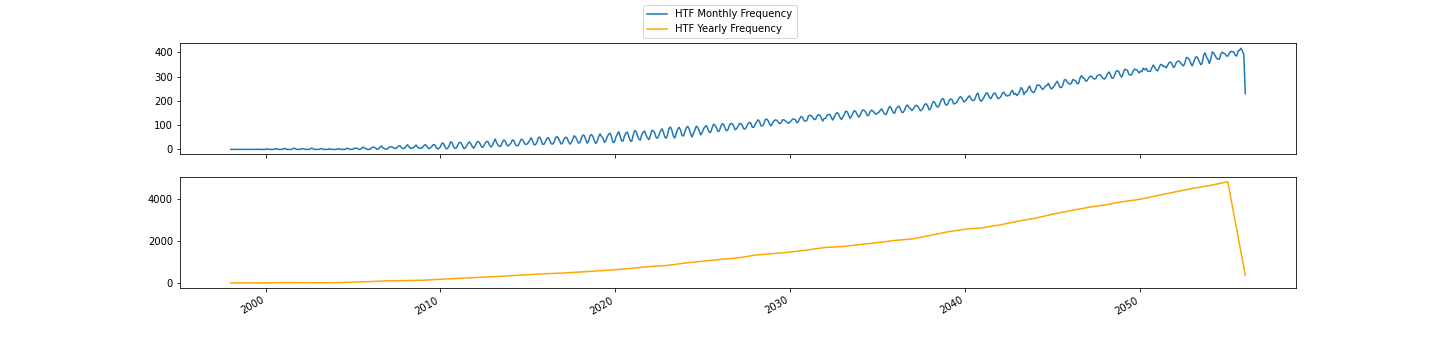

In [129]:
HTF_threshold = 2.7

# counts in a set window for which at least one hourly sea level measurement exceeds HTF threshold
HTF_monthly_frequency = []
HTF_yearly_frequency = []

hours_in_month = 30 * 24  # skewed, not every month is 30 days
for month_index in range(0, len(new_tide_heights), hours_in_month):
    HTF_monthly_frequency.append(0)
    for hour_index in range(month_index, month_index + hours_in_month):
        if hour_index >= len(new_tide_heights):
            break
        if new_tide_heights[hour_index] >= HTF_threshold:
            HTF_monthly_frequency[-1] += 1
months = np.linspace(t[0], t[-1], len(HTF_monthly_frequency))  # this is also not correct

hours_in_year = 365 * 24  # also skewed
for year_index in range(0, len(new_tide_heights), hours_in_year):
    HTF_yearly_frequency.append(0)
    for hour_index in range(year_index, year_index + hours_in_year):
        if hour_index >= len(new_tide_heights):
            break
        if new_tide_heights[hour_index] >= HTF_threshold:
            HTF_yearly_frequency[-1] += 1
years = np.linspace(t[0], t[-1], len(HTF_yearly_frequency))  # this is also not correct

fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=False, sharex=True, figsize=(20, 5))

ax1.plot(months, HTF_monthly_frequency, label='HTF Monthly Frequency')
ax1.xaxis_date()
ax2.plot(years, HTF_yearly_frequency, label='HTF Yearly Frequency', color="orange")
ax2.xaxis_date()
fig.legend(loc='upper center')
fig.autofmt_xdate()